In [1]:
from sample_generator import data_generator, stock_data_generator, stacked_data_generator
import numpy as np

# df = stacked_data_generator(start_date=(2023,1,1),
#                     end_date=(2023,2,2),
#                     perc_anomalies=0.08,
#                     regenerate=False
#                     )

df = stock_data_generator(start_date=(2023,1,1),
                    end_date=(2023,2,2),
                    perc_anomalies=0.08,
                    regenerate=False
                    )

Generating data: c:\Users\manoj\Documents\MANOJ\LocalProjects\intellimind\data\stock_start_23_01_01_end_23_02_02_freq_5T_perc_0.08.csv
Loading from filesystem c:\Users\manoj\Documents\MANOJ\LocalProjects\intellimind\data\stock_start_23_01_01_end_23_02_02_freq_5T_perc_0.08.csv


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9217 entries, 2023-01-01 00:00:00 to 2023-02-02 00:00:00
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   stock_1  9217 non-null   float64
 1   stock_2  9217 non-null   float64
dtypes: float64(2)
memory usage: 216.0 KB


In [3]:
df.head()

,stock_1,stock_2
datetime,,
2023-01-01 00:00:00,2.377889,0.032361
2023-01-01 00:05:00,2.227047,-0.807202
2023-01-01 00:10:00,2.022227,-1.426083
2023-01-01 00:15:00,1.799659,-1.836901
2023-01-01 00:20:00,1.595574,-2.052274


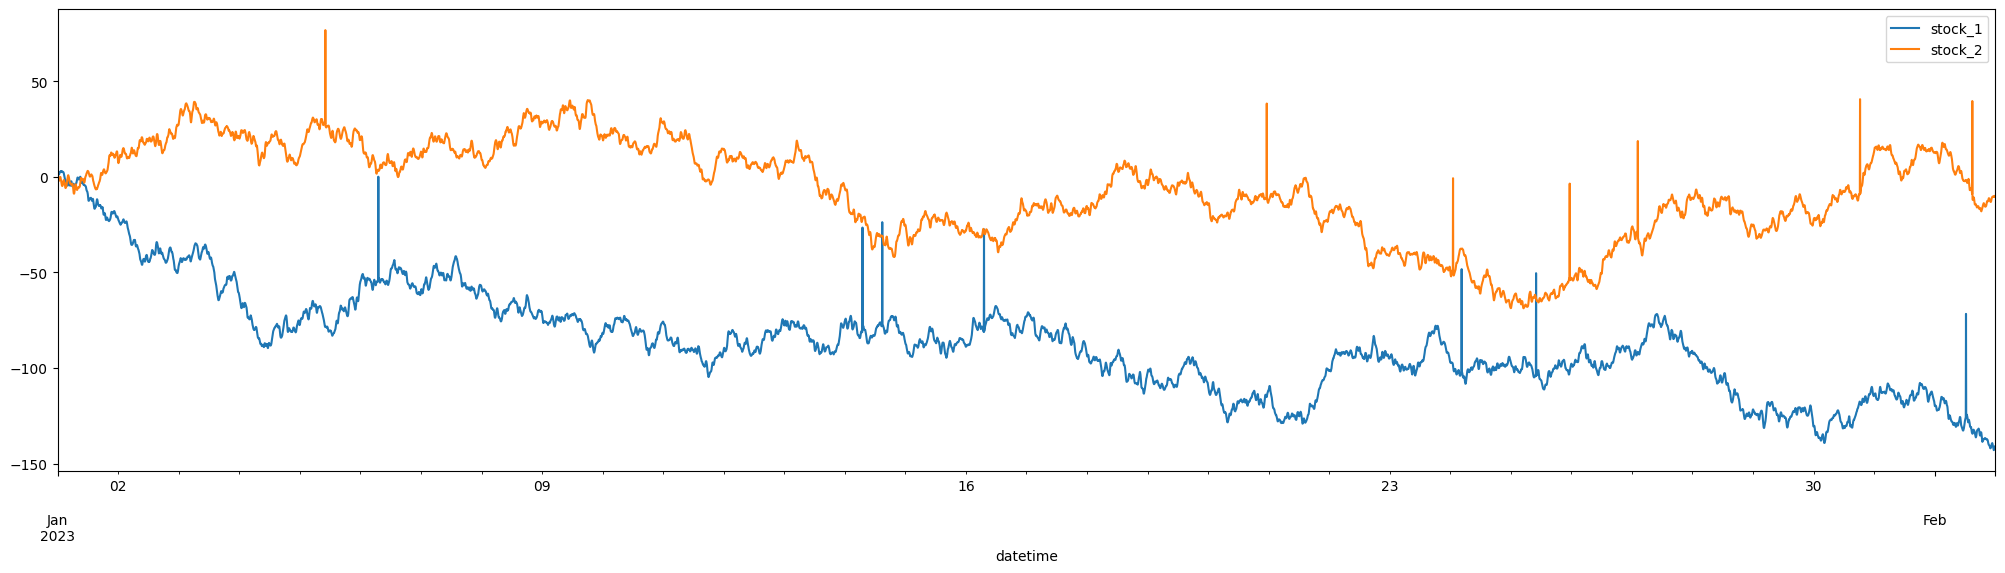

In [4]:
if 'dimension' in df.columns.to_list():
    df[df.dimension=='C'].plot(figsize=(25,6))
else:
    df.plot(figsize=(25,6))

In [5]:
selected_columns = df.columns.to_list()
if 'dimension' in df.columns.to_list():
    selected_columns.remove('dimension')

In [6]:
# Function to create windowed sequences
def create_windows(data, window_size, stride=1):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)
    
    
# Calculate overall mean and std
all_metrics_data = df[selected_columns].to_numpy()

overall_mean, overall_std = np.mean(all_metrics_data, axis=0), np.std(all_metrics_data, axis=0)

In [7]:
# List to store windowed and normalized data for all cell_ids
X_list, y_list = [], []

window_size = 24

if 'dimension' in df.columns.to_list():
    for dim, group in df.groupby('dimension'):
        
        group = group.sort_index()
        # Select only the columns containing the metrics
        metrics_data = group[selected_columns].to_numpy()

        # Normalize the data using the overall mean and std
        metrics_data_normalized = (metrics_data - overall_mean) / overall_std

        # Create windowed sequences
        X_window, y_window = create_windows(metrics_data_normalized, window_size, stride=2)

        # Append to the list
        X_list.append(X_window)
        y_list.append(y_window)
else:
    metrics_data = df[selected_columns].to_numpy()

    # Normalize the data using the overall mean and std
    metrics_data_normalized = (metrics_data - overall_mean) / overall_std

    # Create windowed sequences
    X_window, y_window = create_windows(metrics_data_normalized, window_size, stride=2)

    # Append to the list
    X_list.append(X_window)
    y_list.append(y_window)

In [8]:
X_list = np.concatenate(X_list)
y_list = np.concatenate(y_list)

In [9]:
print(X_list.shape)
print(y_list.shape)

(4597, 24, 2)
(4597, 2)


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
# Split the data into training and validation sets.
split_ratio = 0.8
split_index = int(len(X_list) * split_ratio)
X_train, y_train = X_list[:split_index], y_list[:split_index]
X_val, y_val = X_list[split_index:], y_list[split_index:]
print(X_train.shape)

(3677, 24, 2)


In [12]:
# Step 2: Define a PyTorch Dataset and DataLoader
from torch.utils.data import DataLoader, random_split, TensorDataset
from nn_models import TimeSeriesDataset

batch_size = 128

train_dataset = TimeSeriesDataset(X_train, y_train,'Train',window_size=window_size, output_size=len(selected_columns))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = TimeSeriesDataset(X_val,y_val,'Validation', window_size=window_size, output_size=len(selected_columns))
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=True)

Train tensors moved to GPU
Validation tensors moved to GPU


In [13]:
from nn_models import LSTM_TimeSeriesModel_2, TransformerTimeSeriesModel

In [14]:
# Reduced model hyperparameters
d_model = len(selected_columns)
nhead = 2  # reduced from 2
num_layers = 2  # reduced from 3
dim_feedforward = 64  # reduced from 128
#batch_size = 32  # reduced from 64

# Initialize the reduced Model, Loss, and Optimizer
model = LSTM_TimeSeriesModel_2(d_model, num_layers, d_model)
# model = TransformerTimeSeriesModel(d_model, nhead, num_layers, dim_feedforward)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
#Send model to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
    print("Model moved to GPU")
else:
    print("GPU is not available, using CPU instead")

Model moved to GPU


In [16]:
# Training Loop
import torch
import copy
import os
from tqdm import tqdm

num_epochs = 500
epoch_stage = int(np.sqrt(num_epochs))
patience = 20
best_val_loss = float('inf')
num_epochs_no_improve = 0
best_model = None
best_model_file = 'best_model.pth'  # Define the path where you want to save the model
best_model_file_path = os.path.abspath(os.path.join(os.getcwd(), 'model', best_model_file))

# Optional: Gradient clipping
clip_value = 1.0

for epoch in range(num_epochs):
    model.train()

    # for batch_idx, (X_train_batch, y_train_batch) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
    for batch_idx, (X_train_batch, y_train_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(X_train_batch)
        loss = criterion(outputs, y_train_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()


    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()
        val_loss /= len(val_loader)

    if (epoch) % epoch_stage == 0 or epoch == num_epochs - 1:
        print(f"Epoch  [{epoch+1}/{num_epochs}] | Training Loss: {loss.item()}, Validation Loss: {val_loss}")

    # Checkpoint and Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        num_epochs_no_improve = 0
        best_model = copy.deepcopy(model.state_dict())
        torch.save(best_model, best_model_file_path)  # Save the best model state to disk
    else:
        num_epochs_no_improve += 1

    if num_epochs_no_improve == patience:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {loss.item()}, Validation Loss: {val_loss}")
        print(f"Early stopping triggered. Validation loss did not decrease for {patience} consecutive epochs.")
        break




Epoch  [1/500] | Training Loss: 2.55328631401062, Validation Loss: 1.5626876205205917
Epoch  [23/500] | Training Loss: 1.5426373481750488, Validation Loss: 1.081657126545906
Epoch  [45/500] | Training Loss: 0.39237815141677856, Validation Loss: 0.7210637703537941
Epoch  [67/500] | Training Loss: 0.14844940602779388, Validation Loss: 0.6205261945724487
Epoch  [89/500] | Training Loss: 0.0727282166481018, Validation Loss: 0.5650649294257164
Epoch  [111/500] | Training Loss: 0.04749105125665665, Validation Loss: 0.47808432951569557
Epoch  [133/500] | Training Loss: 0.029990341514348984, Validation Loss: 0.3589741475880146
Epoch  [155/500] | Training Loss: 0.024544693529605865, Validation Loss: 0.19967780075967312
Epoch  [177/500] | Training Loss: 0.02363451011478901, Validation Loss: 0.10925199184566736
Epoch  [199/500] | Training Loss: 0.023464450612664223, Validation Loss: 0.06937776878476143
Epoch  [221/500] | Training Loss: 0.023521309718489647, Validation Loss: 0.05406958842650056
Ep

In [17]:
# Load the best model for use
model.load_state_dict(torch.load(best_model_file_path))

checkpoint = {'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
              'window_size': window_size,
              'overall_mean': overall_mean,
              'overall_std': overall_std,
              # ... any other data
             }
best_model_checkpt_file = 'best_model_checkpoint.pth'  # Define the path where you want to save the checkpoint
best_model_checkpt_file_path = os.path.abspath(os.path.join(os.getcwd(), 'model', best_model_checkpt_file))
torch.save(checkpoint, best_model_checkpt_file_path)

In [18]:
model.eval()
all_reconstruction_errors = []

for batch_idx, (X_batch, y_batch) in enumerate(val_loader):
    with torch.no_grad():
        y_pred = model(X_batch)
        reconstruction_error = ((y_batch.cpu() - y_pred.cpu()) ** 2).mean(dim=1).numpy()
        all_reconstruction_errors.extend(reconstruction_error)

all_reconstruction_errors = np.array(all_reconstruction_errors)

In [19]:
reconstruction_checkpt_file = 'all_reconstruction_error.npy'  # Define the path where you want to save the checkpoint
reconstruction_checkpt_file_path = os.path.abspath(os.path.join(os.getcwd(), 'model', reconstruction_checkpt_file))

np.save(reconstruction_checkpt_file_path, all_reconstruction_errors)

In [20]:
import pandas as pd
# Create bins 
bin_ranges = pd.cut(all_reconstruction_errors, bins=50)

# Count the frequency of each bin
bin_counts = bin_ranges.value_counts().sort_index()

# Create a Pandas DataFrame for better visualization
table = pd.DataFrame({
    'Bin_Range': bin_counts.index.astype(str),
    'Frequency': bin_counts.values
})

# Print the table
print(table)

             Bin_Range  Frequency
0   (-0.00197, 0.0395]        911
1     (0.0395, 0.0789]          6
2      (0.0789, 0.118]          1
3       (0.118, 0.158]          0
4       (0.158, 0.197]          0
5       (0.197, 0.237]          0
6       (0.237, 0.276]          0
7       (0.276, 0.316]          0
8       (0.316, 0.355]          0
9       (0.355, 0.395]          0
10      (0.395, 0.434]          0
11      (0.434, 0.473]          0
12      (0.473, 0.513]          0
13      (0.513, 0.552]          0
14      (0.552, 0.592]          0
15      (0.592, 0.631]          0
16      (0.631, 0.671]          0
17       (0.671, 0.71]          0
18        (0.71, 0.75]          0
19       (0.75, 0.789]          0
20      (0.789, 0.829]          0
21      (0.829, 0.868]          0
22      (0.868, 0.907]          0
23      (0.907, 0.947]          0
24      (0.947, 0.986]          0
25      (0.986, 1.026]          0
26      (1.026, 1.065]          0
27      (1.065, 1.105]          0
28      (1.105

In [21]:
threshold = np.percentile(all_reconstruction_errors, 99.9)
threshold

1.9531103385686903

Perform the prediction on the entire dataset now for one of the dimension if it is present

In [22]:
if 'dimension' in df.columns.to_list():
    
    df_ml = df.loc[df['dimension']=='B']
    df_ml = df_ml.sort_index()
else:
    df_ml = df

In [23]:

new_metrics_data = df_ml[selected_columns].to_numpy()

# Using `create_windows` function to create windowed sequences
new_X_window, new_y_window = create_windows(new_metrics_data, window_size)

# Step 4: Normalize the windowed data using original mean and std
new_X_window_normalized = (new_X_window - overall_mean) / overall_std
new_y_window_normalized = (new_y_window - overall_mean) / overall_std



# Create DataLoader if needed
new_dataset = TimeSeriesDataset(new_X_window_normalized, new_y_window_normalized,'All data', window_size=window_size, output_size=len(selected_columns))
new_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)



All data tensors moved to GPU


In [24]:
model.eval()
anomalies = []
filt_reconstruction_errors = []

for batch_idx, (X_batch, y_batch) in enumerate(new_loader):  # Replace val_loader with your test_loader if using new data
    with torch.no_grad():
        y_pred = model(X_batch)
        reconstruction_error = ((y_batch.cpu() - y_pred.cpu()) ** 2).mean(dim=1).numpy()
        
        filt_reconstruction_errors.extend(reconstruction_error)
        batch_anomalies = reconstruction_error > threshold
        anomalies.extend(batch_anomalies)

filt_reconstruction_errors = np.array(filt_reconstruction_errors)
anomalies = np.array(anomalies)
num_anomalies = np.sum(anomalies)
print(f"Number of anomalies: {num_anomalies}")

Number of anomalies: 11


In [25]:
#Here we calculate the number of anomalies based on the pre-calculated Anomaly score (reconstruction_errors)
anomalies_o = filt_reconstruction_errors > threshold
num_anomalies_o = np.sum(anomalies_o)
print(f"Number of anomalies: {num_anomalies_o}")

Number of anomalies: 11


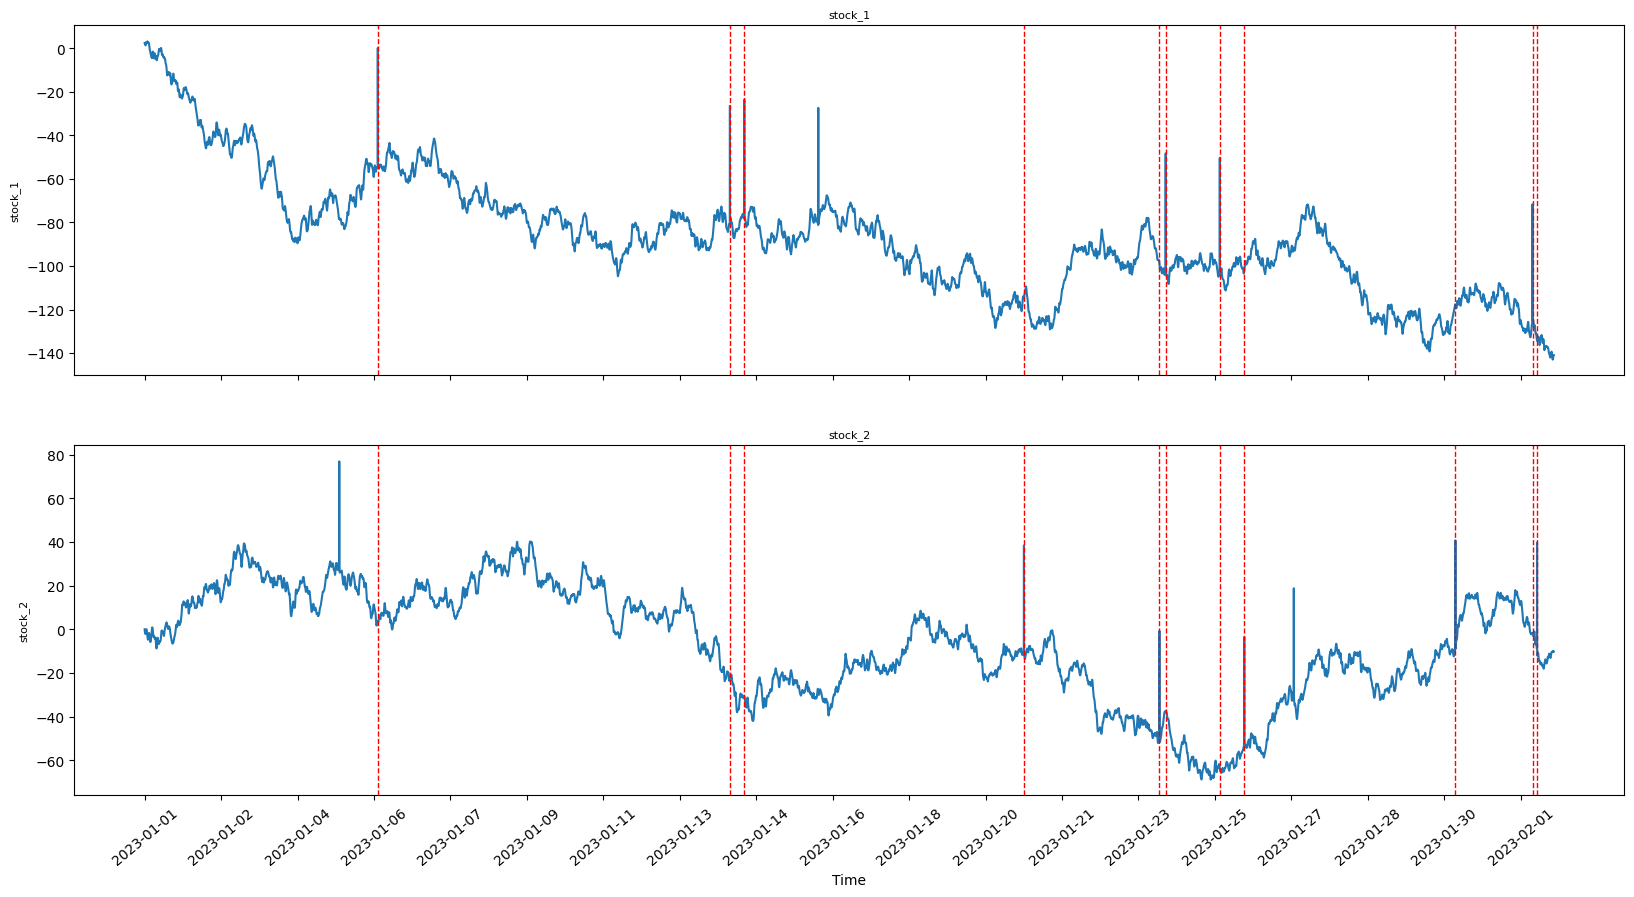

In [26]:

import matplotlib.pyplot as plt

# Prepare anomaly indices (same as previous examples)
anomalous_indexes_val = np.where(anomalies_o)[0]
original_anomalous_indexes = anomalous_indexes_val + window_size
anomaly_times = df_ml.index[original_anomalous_indexes]

# Metrics to be plotted
metrics = selected_columns

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 10), sharex=True)

# Loop through metrics and plot
for i, metric in enumerate(metrics):
    axes[i].plot(df_ml.index, df_ml[metric], label=f'{metric} Data')
    #axes[i].scatter(anomaly_times, pm_data[metric].iloc[original_anomalous_indexes], color='red', label='Anomaly')
    axes[i].set_title(f'{metric}',fontsize=8)
    axes[i].set_ylabel(metric ,fontsize=8)
    for anomaly_time in anomaly_times:
        axes[i].axvline(x=anomaly_time, color='red', linestyle='--', linewidth=1, label='Anomaly')
    #axes[i].legend()


# Label the shared x-axis
axes[-1].set_xlabel('Time')
ticks_to_use = df_ml.index[::500]  # Choose every 10th time point
plt.xticks(ticks_to_use)
plt.xticks(rotation=40)

# Show plot
plt.show()